#### Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys
from sklearn.feature_selection import VarianceThreshold

# Load Data

### Add path

In [2]:
# Path to excel file with the tested molecules
path = 'tested_molecules.csv'

In [15]:
molecular_data = pd.read_csv('tested_molecules.csv')

def compute_2Ddescriptors(smiles):
    '''Compute 2D descriptors for a given SMILES string using RDKit.
    Parameters:
        smiles (str): SMILES string
    Returns:
        list: List of descriptor values'''
    mol = Chem.MolFromSmiles(smiles)
    descriptors = [desc[1](mol) for desc in Descriptors.descList if not desc[0].startswith('fr_')]
    return descriptors

# Compute descriptor values for each SMILES string and add as new columns
descriptor_columns = [desc[0] for desc in Descriptors.descList if not desc[0].startswith('fr_')]
molecular_data[descriptor_columns] = molecular_data['SMILES'].apply(lambda x: pd.Series(compute_2Ddescriptors(x)))
molecular_data.head()

,SMILES,PKM2_inhibition,ERK2_inhibition,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR
0,C=C(C)c1nc(N)nc(N)n1,0,0,5.313889,5.313889,0.120833,0.120833,0.592228,9.545455,151.173,...,5.0,2.0,5.0,1.0,0.0,0.0,0.0,1.0,0.06910,43.3598
1,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0,11.238954,11.238954,0.225308,-0.366756,0.785414,10.470588,250.681,...,3.0,0.0,4.0,3.0,0.0,0.0,0.0,2.0,3.23272,67.7090
2,C=CCNC(=O)CCCC(=O)NCC=C,0,0,11.090706,11.090706,0.049610,-0.049610,0.581062,9.066667,210.277,...,2.0,2.0,4.0,8.0,0.0,0.0,0.0,0.0,0.76110,60.2644
3,C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0,0,11.892238,11.892238,0.076632,-0.457824,0.441090,10.411765,232.239,...,4.0,0.0,5.0,3.0,0.0,0.0,0.0,2.0,0.55792,63.5490
4,C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,0,0,11.693580,11.693580,0.012315,-0.498260,0.720343,9.933333,226.663,...,4.0,0.0,5.0,4.0,0.0,0.0,0.0,1.0,1.03540,60.3660


In [10]:
def get_maccs_keys(smiles):
    '''Generate MACCS keys for a given SMILES string using RDKit.
    Parameters: 
        smiles (str): SMILES string
    Returns:
        list: List of MACCS keys'''
    # Convert SMILES to RDKit molecule
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return [0] * 166  # Return an array of zeros if the molecule is invalid
    # Generate MACCS keys for the molecule
    maccs_fp = MACCSkeys.GenMACCSKeys(molecule)
    # Convert the fingerprint to a list of integers (0 or 1) and skip the first bit
    return list(maccs_fp)[1:]

# Store maccs_keys
maccs_keys = molecular_data['SMILES'].apply(get_maccs_keys)

# Process the data to find useful 2D descriptors

In [17]:
# Check if there is any missing data and duplicated rows
missing_count = molecular_data.isnull().sum().sum()
print("Number of missing values in each column:\n", missing_count)
any_missing_values = molecular_data.isna().values.any()
print("Are there any missing values in the DataFrame?",any_missing_values)

# Check for infinite values
inf_values = molecular_data.isin([np.inf, -np.inf]).sum().sum()
print("Number of infinite values in each column:")
print(inf_values)

# Count the number of duplicated rows
duplicate_count = molecular_data.duplicated().sum()
print("Number of duplicated rows:", duplicate_count)

# Check which rows only contain one value
single_value_columns = molecular_data.columns[molecular_data.nunique() == 1]
print("Column containing only one value:", single_value_columns)
# Remove the columns with only one unique value from the DataFrame
molecular_data = molecular_data.drop(columns=single_value_columns)

# Create dataframes for SMILES, PKM2 and ERK2
smiles = molecular_data['SMILES']
PKM2_inhibition = molecular_data['PKM2_inhibition']
ERK2_inhibition = molecular_data['ERK2_inhibition']
data = molecular_data.iloc[:, 4::]

# Create the labels DataFrame
labels = pd.DataFrame(index=df.index, columns=['labels'])
# Assign labels based on conditions
labels['Class'] = df['PKM2_inhibition'] + 2 * df['ERK2_inhibition']
# Class labels
class_labels = {
    0: 'None',
    1: 'PKM2',
    2: 'ERK2',
    3: 'PKM2 and ERK2',
}

# Assuming 'data' is your DataFrame
data = data.dropna(axis=1)
data.head()

Number of missing values in each column:
 0
Are there any missing values in the DataFrame? False
Number of infinite values in each column:
0
Number of duplicated rows: 0
Column containing only one value: Index(['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'EState_VSA11'], dtype='object')


,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR
0,5.313889,0.120833,0.120833,0.592228,9.545455,151.173,142.101,151.085795,58.0,0.224863,...,5.0,2.0,5.0,1.0,0.0,0.0,0.0,1.0,0.06910,43.3598
1,11.238954,0.225308,-0.366756,0.785414,10.470588,250.681,239.593,250.039672,88.0,0.335962,...,3.0,0.0,4.0,3.0,0.0,0.0,0.0,2.0,3.23272,67.7090
2,11.090706,0.049610,-0.049610,0.581062,9.066667,210.277,192.133,210.136828,84.0,0.219755,...,2.0,2.0,4.0,8.0,0.0,0.0,0.0,0.0,0.76110,60.2644
3,11.892238,0.076632,-0.457824,0.441090,10.411765,232.239,220.143,232.084792,88.0,0.351624,...,4.0,0.0,5.0,3.0,0.0,0.0,0.0,2.0,0.55792,63.5490
4,11.693580,0.012315,-0.498260,0.720343,9.933333,226.663,215.575,226.050905,80.0,0.331143,...,4.0,0.0,5.0,4.0,0.0,0.0,0.0,1.0,1.03540,60.3660


### Distribution of data

#### Correlation data

Total correlated variable pairs (correlation > 0.9): 104


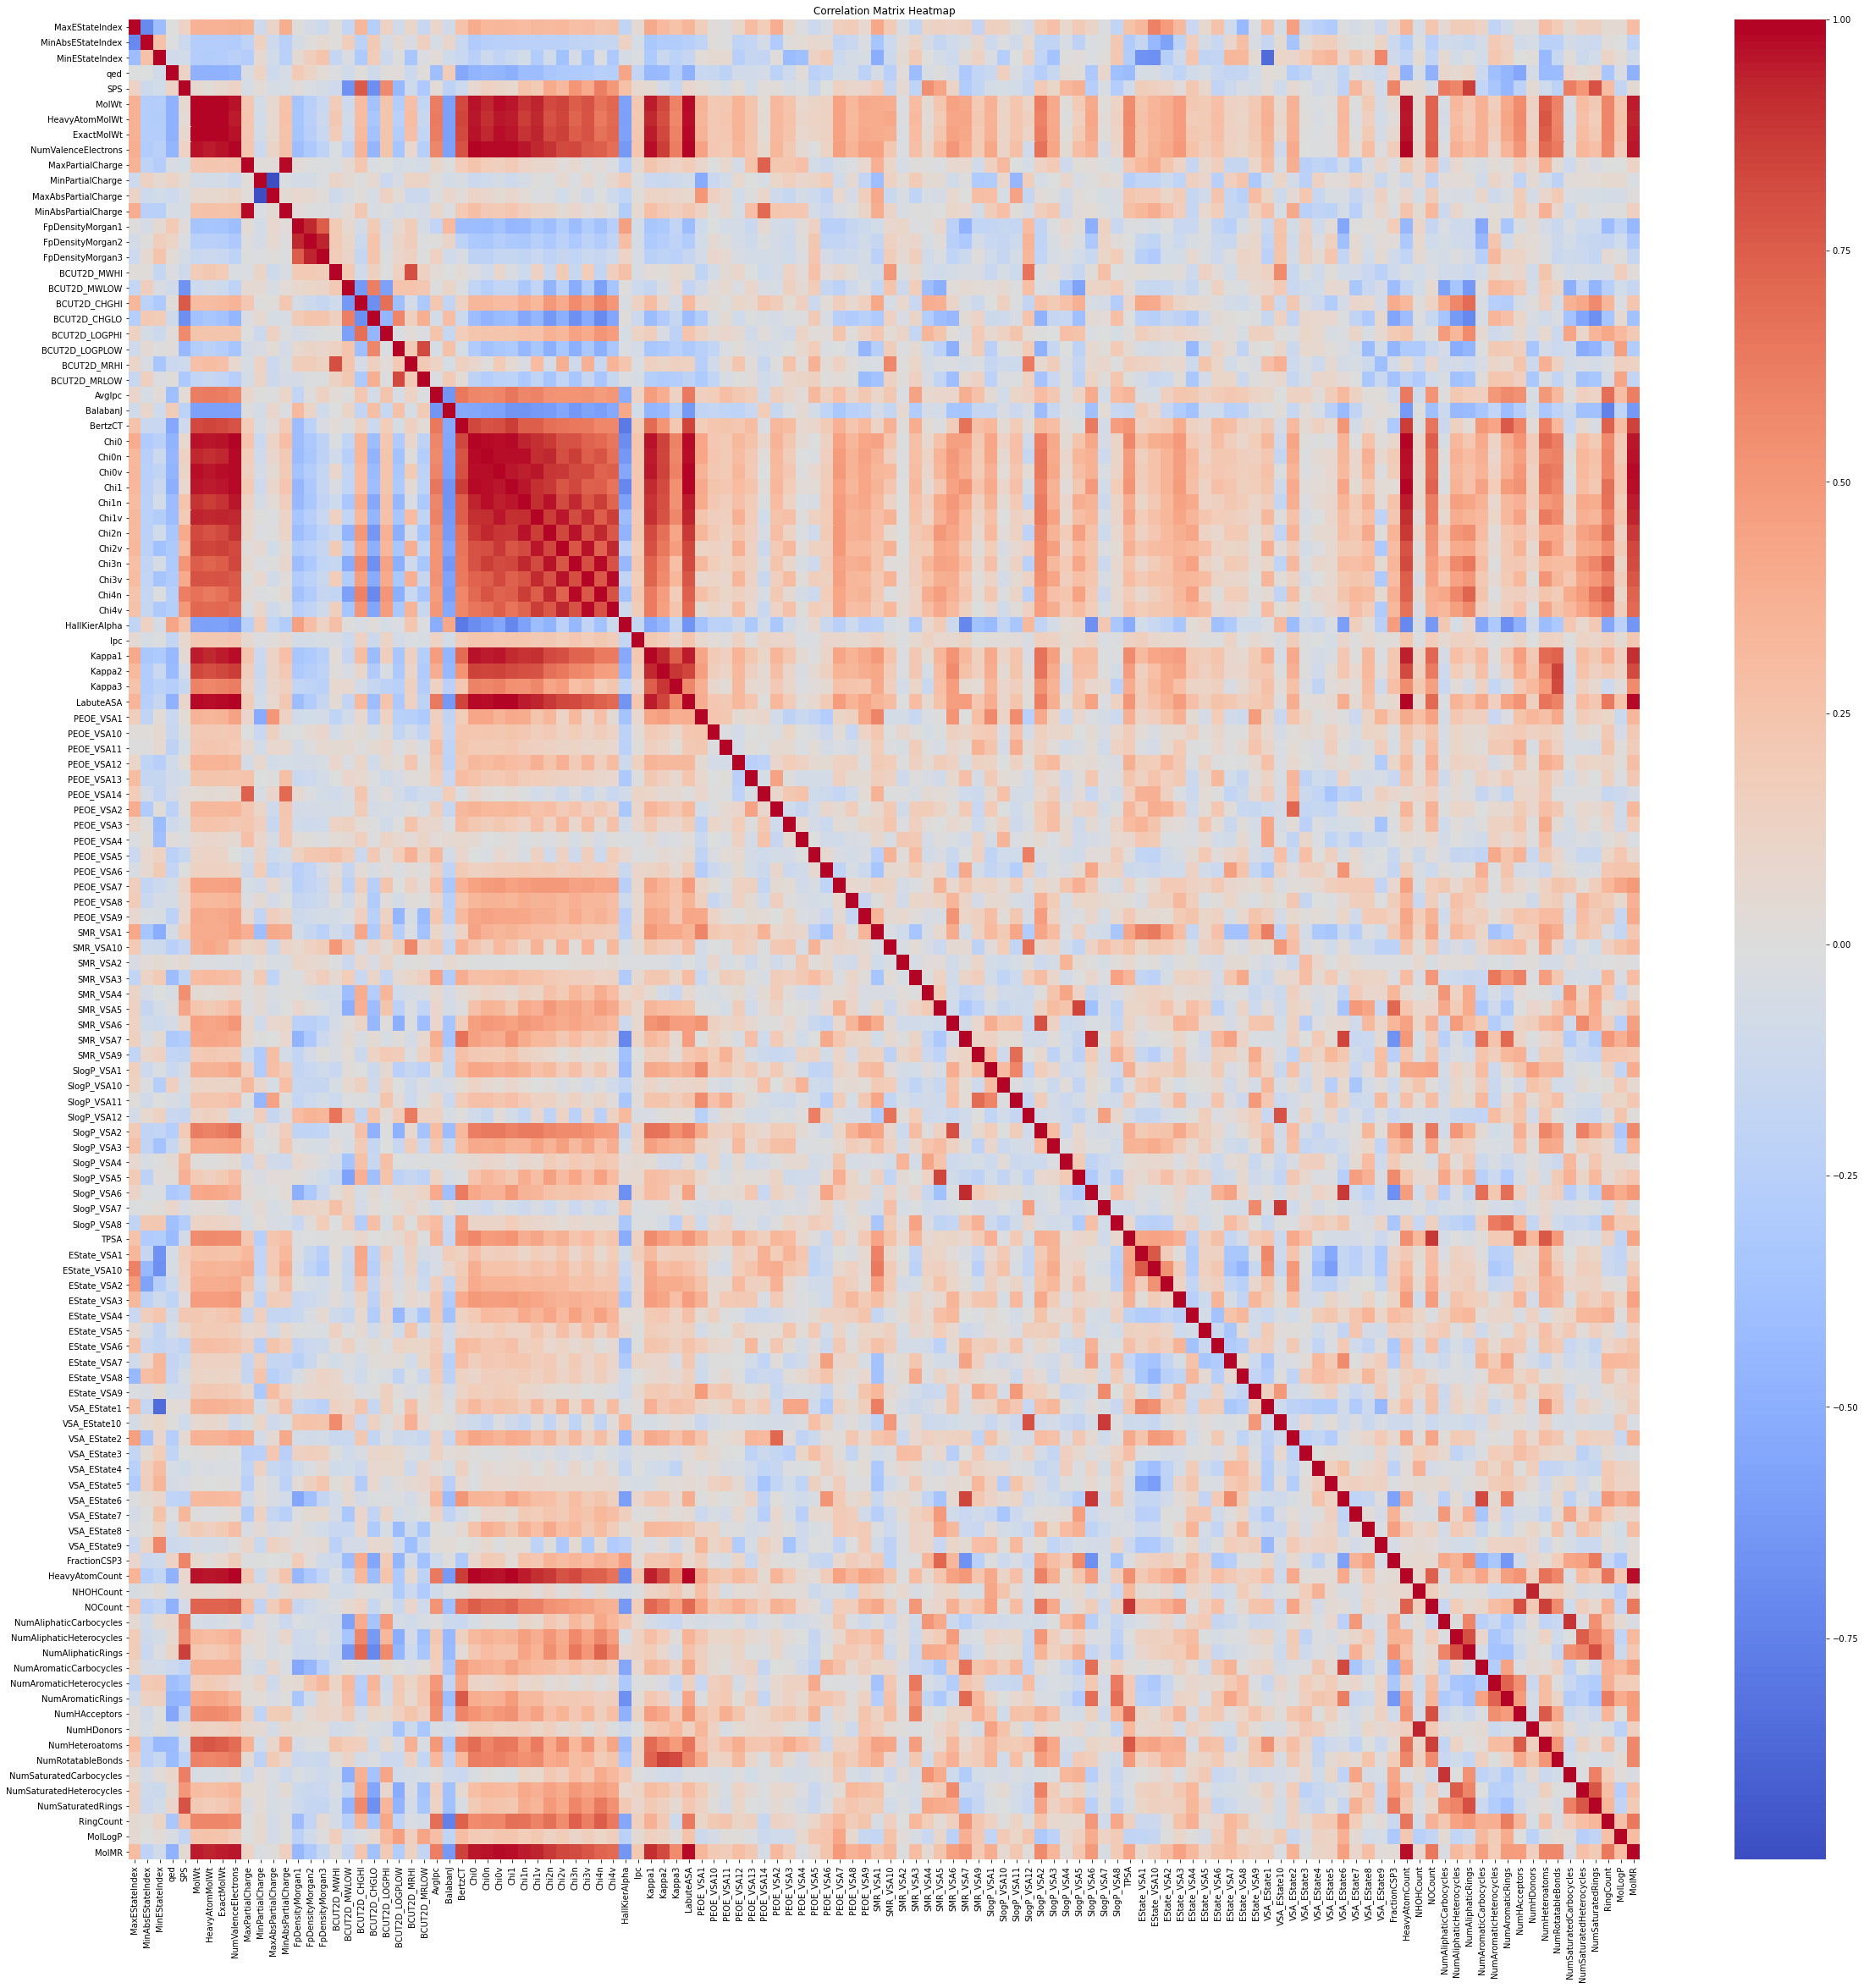

In [18]:
# Compute the correlation matrix
correlation_matrix = data.corr()

# Threshold correlation
correlation_value = 0.90
# Create a mask for correlations greater than the threhold
highly_correlated_mask = np.abs(correlation_matrix) > correlation_value
# Set the diagonal values to FALSE
np.fill_diagonal(highly_correlated_mask.values, False)
# Extract the upper triangle of the correlation matrix
upper_triangle_mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
# Apply the upper triangle mask to the highly correlated mask
highly_correlated_upper = highly_correlated_mask & upper_triangle_mask
# Count the number of highly correlated pairs
highly_correlated_count = highly_correlated_upper.sum()

print(f"Total correlated variable pairs (correlation > {correlation_value}):", highly_correlated_count.sum())

# Generate a heatmap
plt.figure(figsize=(40,40))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

 ### Remove highly correlated values( > 0.90) and show new heatmap

In [19]:
# Assuming 'df' is your DataFrame
# Compute the correlation matrix
correlation_matrix = data.corr()

# Find highly correlated pairs
highly_correlated_pairs = {}
for col in correlation_matrix.columns:
    correlated_cols = correlation_matrix.index[correlation_matrix[col].abs() > 0.9].tolist()
    correlated_cols.remove(col)  # Remove the column itself from the list
    if correlated_cols:
        highly_correlated_pairs[col] = correlated_cols

# Drop the variable with the highest average correlation
for col, correlated_cols in highly_correlated_pairs.items():
    avg_correlation = {}
    for correlated_col in correlated_cols:
        if correlated_col in data.columns:  # Check if the column exists in the DataFrame
            avg_correlation[correlated_col] = correlation_matrix[correlated_col].abs().mean()
    if avg_correlation:
        col_to_drop = max(avg_correlation, key=avg_correlation.get)
        data.drop(col_to_drop, axis=1, inplace=True)

# Display the resulting DataFrame
data.head()

,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,...,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP
0,5.313889,0.120833,0.120833,0.592228,9.545455,2.000000,15.136768,10.324116,1.999502,-1.985357,...,1.0,1.0,5.0,5.0,1.0,0.0,0.0,0.0,1.0,0.06910
1,11.238954,0.225308,-0.366756,0.785414,10.470588,2.941176,35.495704,10.129819,2.036408,-2.058730,...,1.0,2.0,3.0,4.0,3.0,0.0,0.0,0.0,2.0,3.23272
2,11.090706,0.049610,-0.049610,0.581062,9.066667,1.666667,16.151392,10.194131,2.025367,-2.024953,...,0.0,0.0,2.0,4.0,8.0,0.0,0.0,0.0,0.0,0.76110
3,11.892238,0.076632,-0.457824,0.441090,10.411765,2.941176,16.658607,10.266933,2.165357,-2.109327,...,1.0,2.0,4.0,5.0,3.0,0.0,0.0,0.0,2.0,0.55792
4,11.693580,0.012315,-0.498260,0.720343,9.933333,2.400000,35.495691,10.486281,2.068968,-2.066519,...,1.0,1.0,4.0,5.0,4.0,0.0,0.0,0.0,1.0,1.03540


Total correlated variable pairs (correlation > 0.9): 0


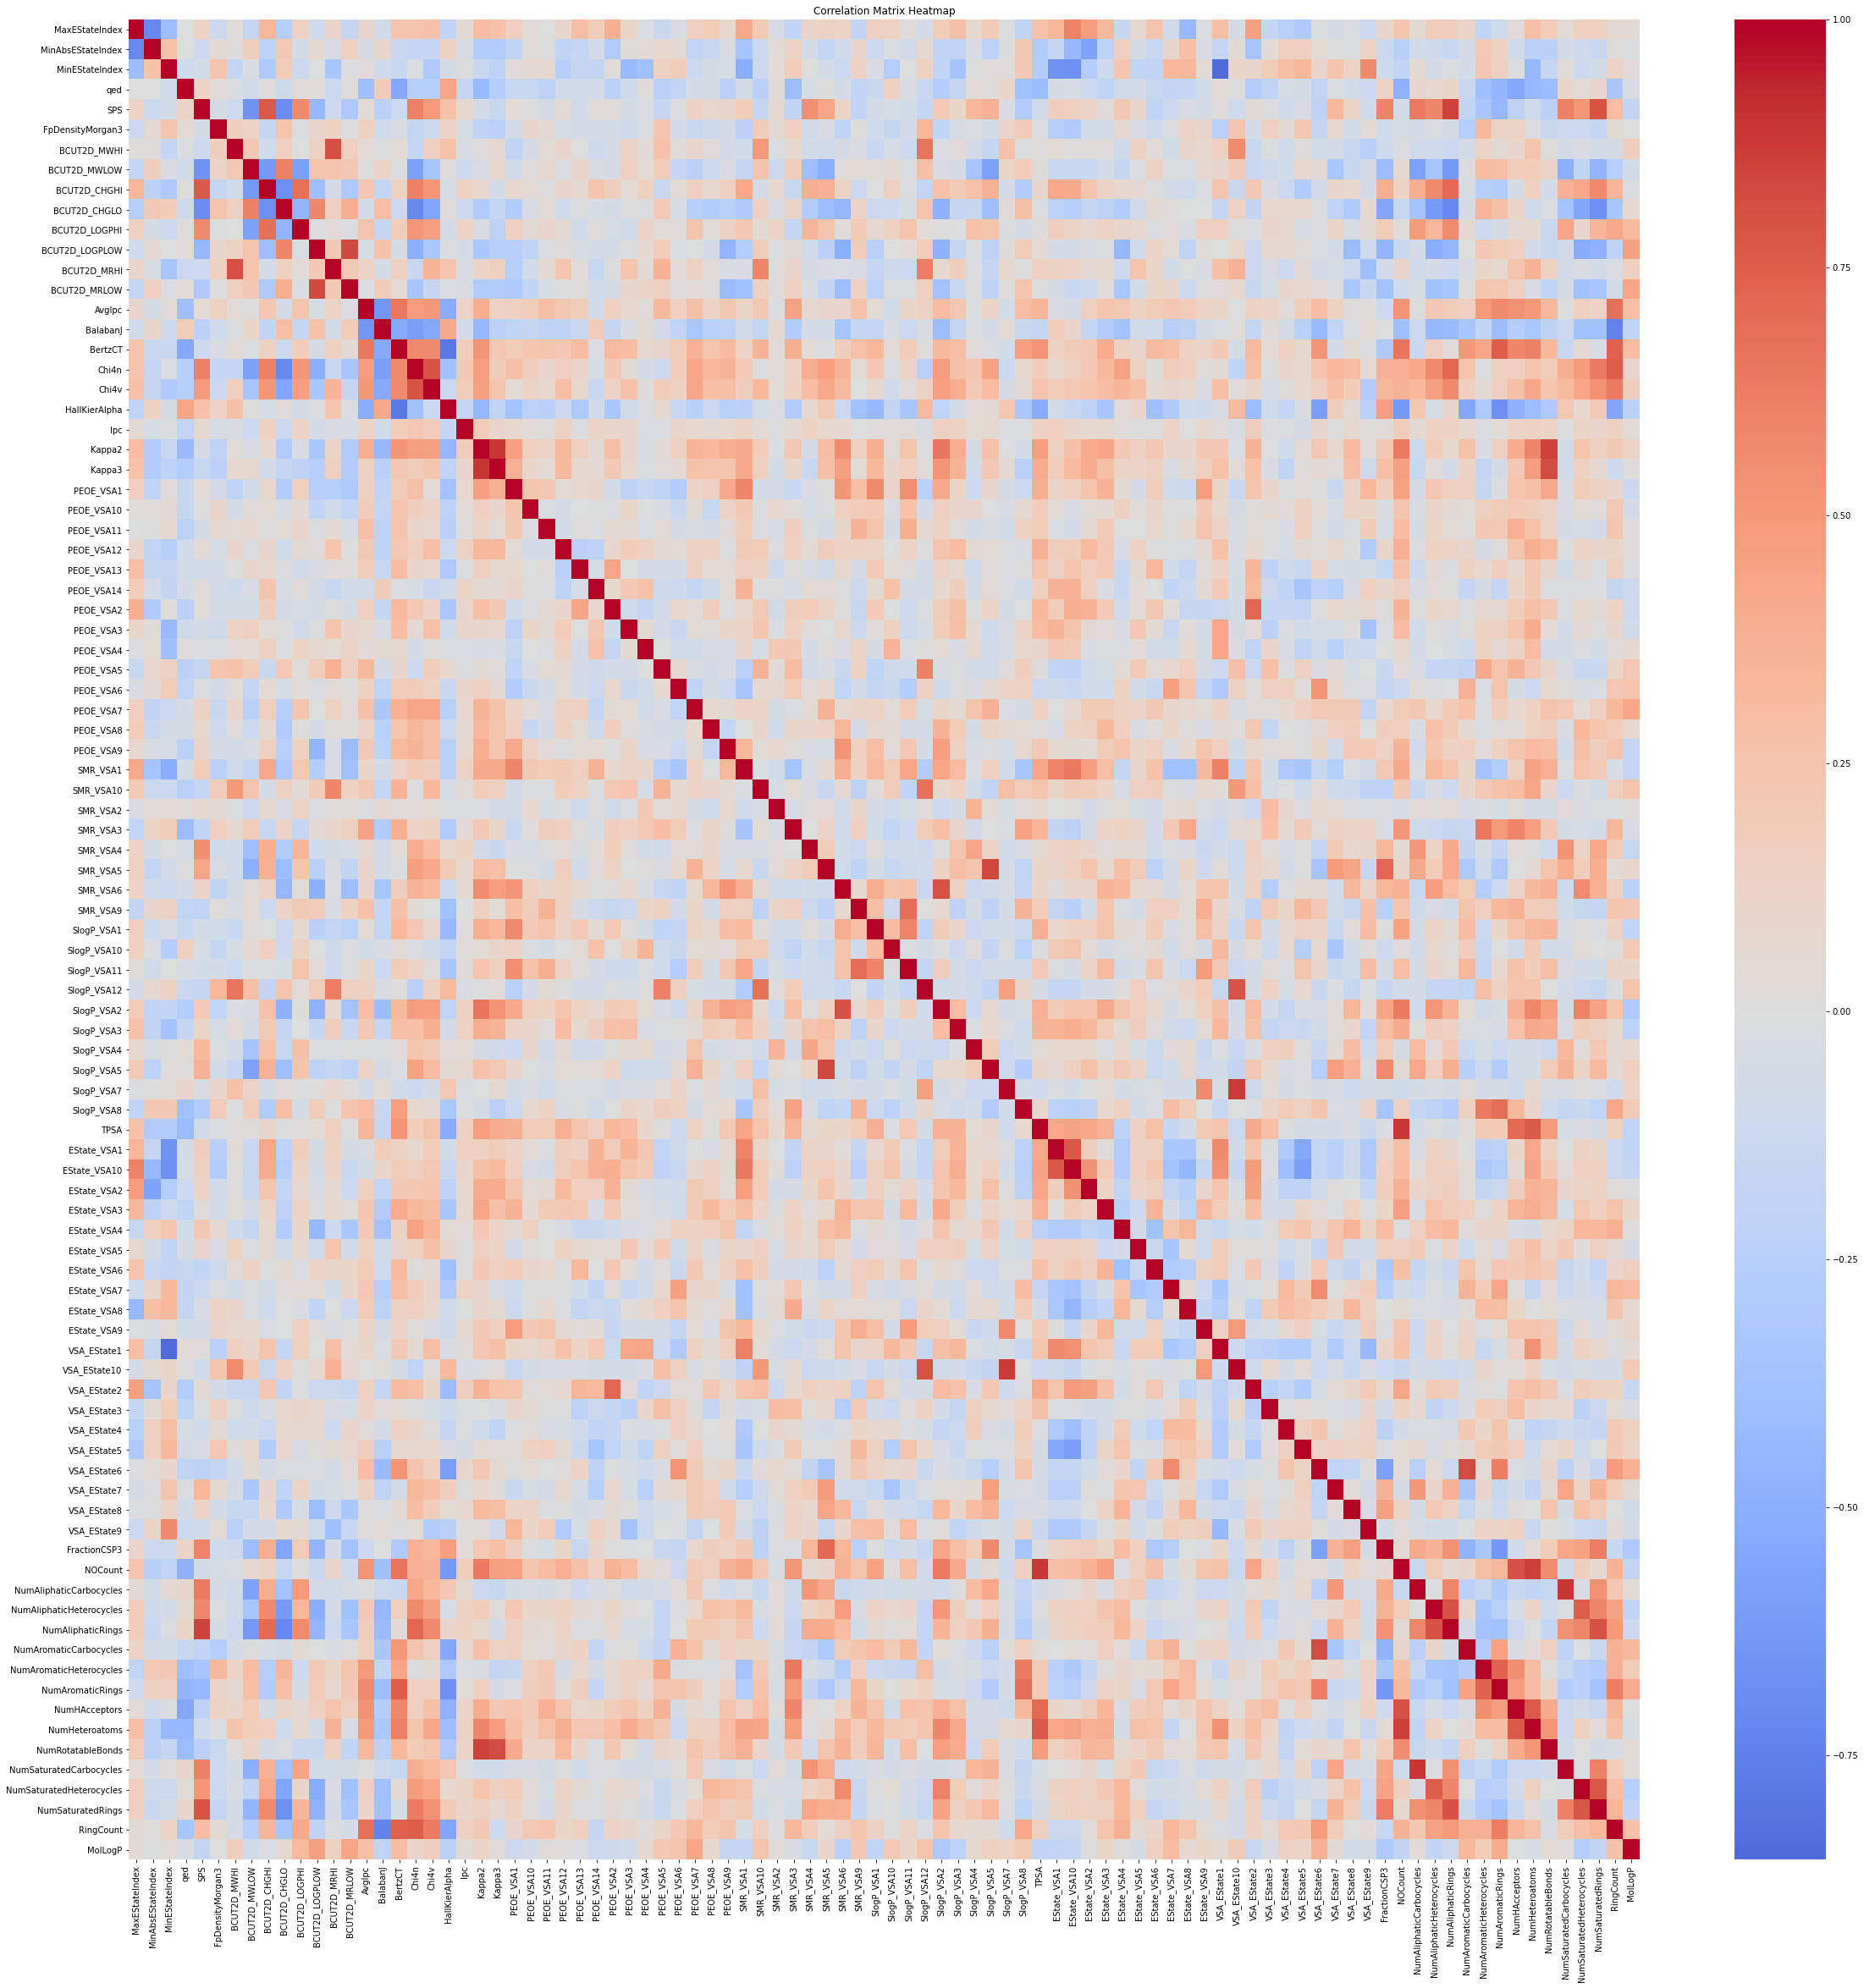

,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,...,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP
0,5.313889,0.120833,0.120833,0.592228,9.545455,2.000000,15.136768,10.324116,1.999502,-1.985357,...,1.0,1.0,5.0,5.0,1.0,0.0,0.0,0.0,1.0,0.06910
1,11.238954,0.225308,-0.366756,0.785414,10.470588,2.941176,35.495704,10.129819,2.036408,-2.058730,...,1.0,2.0,3.0,4.0,3.0,0.0,0.0,0.0,2.0,3.23272
2,11.090706,0.049610,-0.049610,0.581062,9.066667,1.666667,16.151392,10.194131,2.025367,-2.024953,...,0.0,0.0,2.0,4.0,8.0,0.0,0.0,0.0,0.0,0.76110
3,11.892238,0.076632,-0.457824,0.441090,10.411765,2.941176,16.658607,10.266933,2.165357,-2.109327,...,1.0,2.0,4.0,5.0,3.0,0.0,0.0,0.0,2.0,0.55792
4,11.693580,0.012315,-0.498260,0.720343,9.933333,2.400000,35.495691,10.486281,2.068968,-2.066519,...,1.0,1.0,4.0,5.0,4.0,0.0,0.0,0.0,1.0,1.03540


In [20]:
# Compute the correlation matrix
correlation_matrix = data.corr()

# Threshold correlation
correlation_value = 0.90
# Create a mask for correlations greater than the threhold
highly_correlated_mask = np.abs(correlation_matrix) > correlation_value
# Set the diagonal values to FALSE
np.fill_diagonal(highly_correlated_mask.values, False)
# Extract the upper triangle of the correlation matrix
upper_triangle_mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
# Apply the upper triangle mask to the highly correlated mask
highly_correlated_upper = highly_correlated_mask & upper_triangle_mask
# Count the number of highly correlated pairs
highly_correlated_count = highly_correlated_upper.sum()

print(f"Total correlated variable pairs (correlation > {correlation_value}):", highly_correlated_count.sum())

# Generate a heatmap
plt.figure(figsize=(40,40))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()
data.head()

## Remove variables with low variance

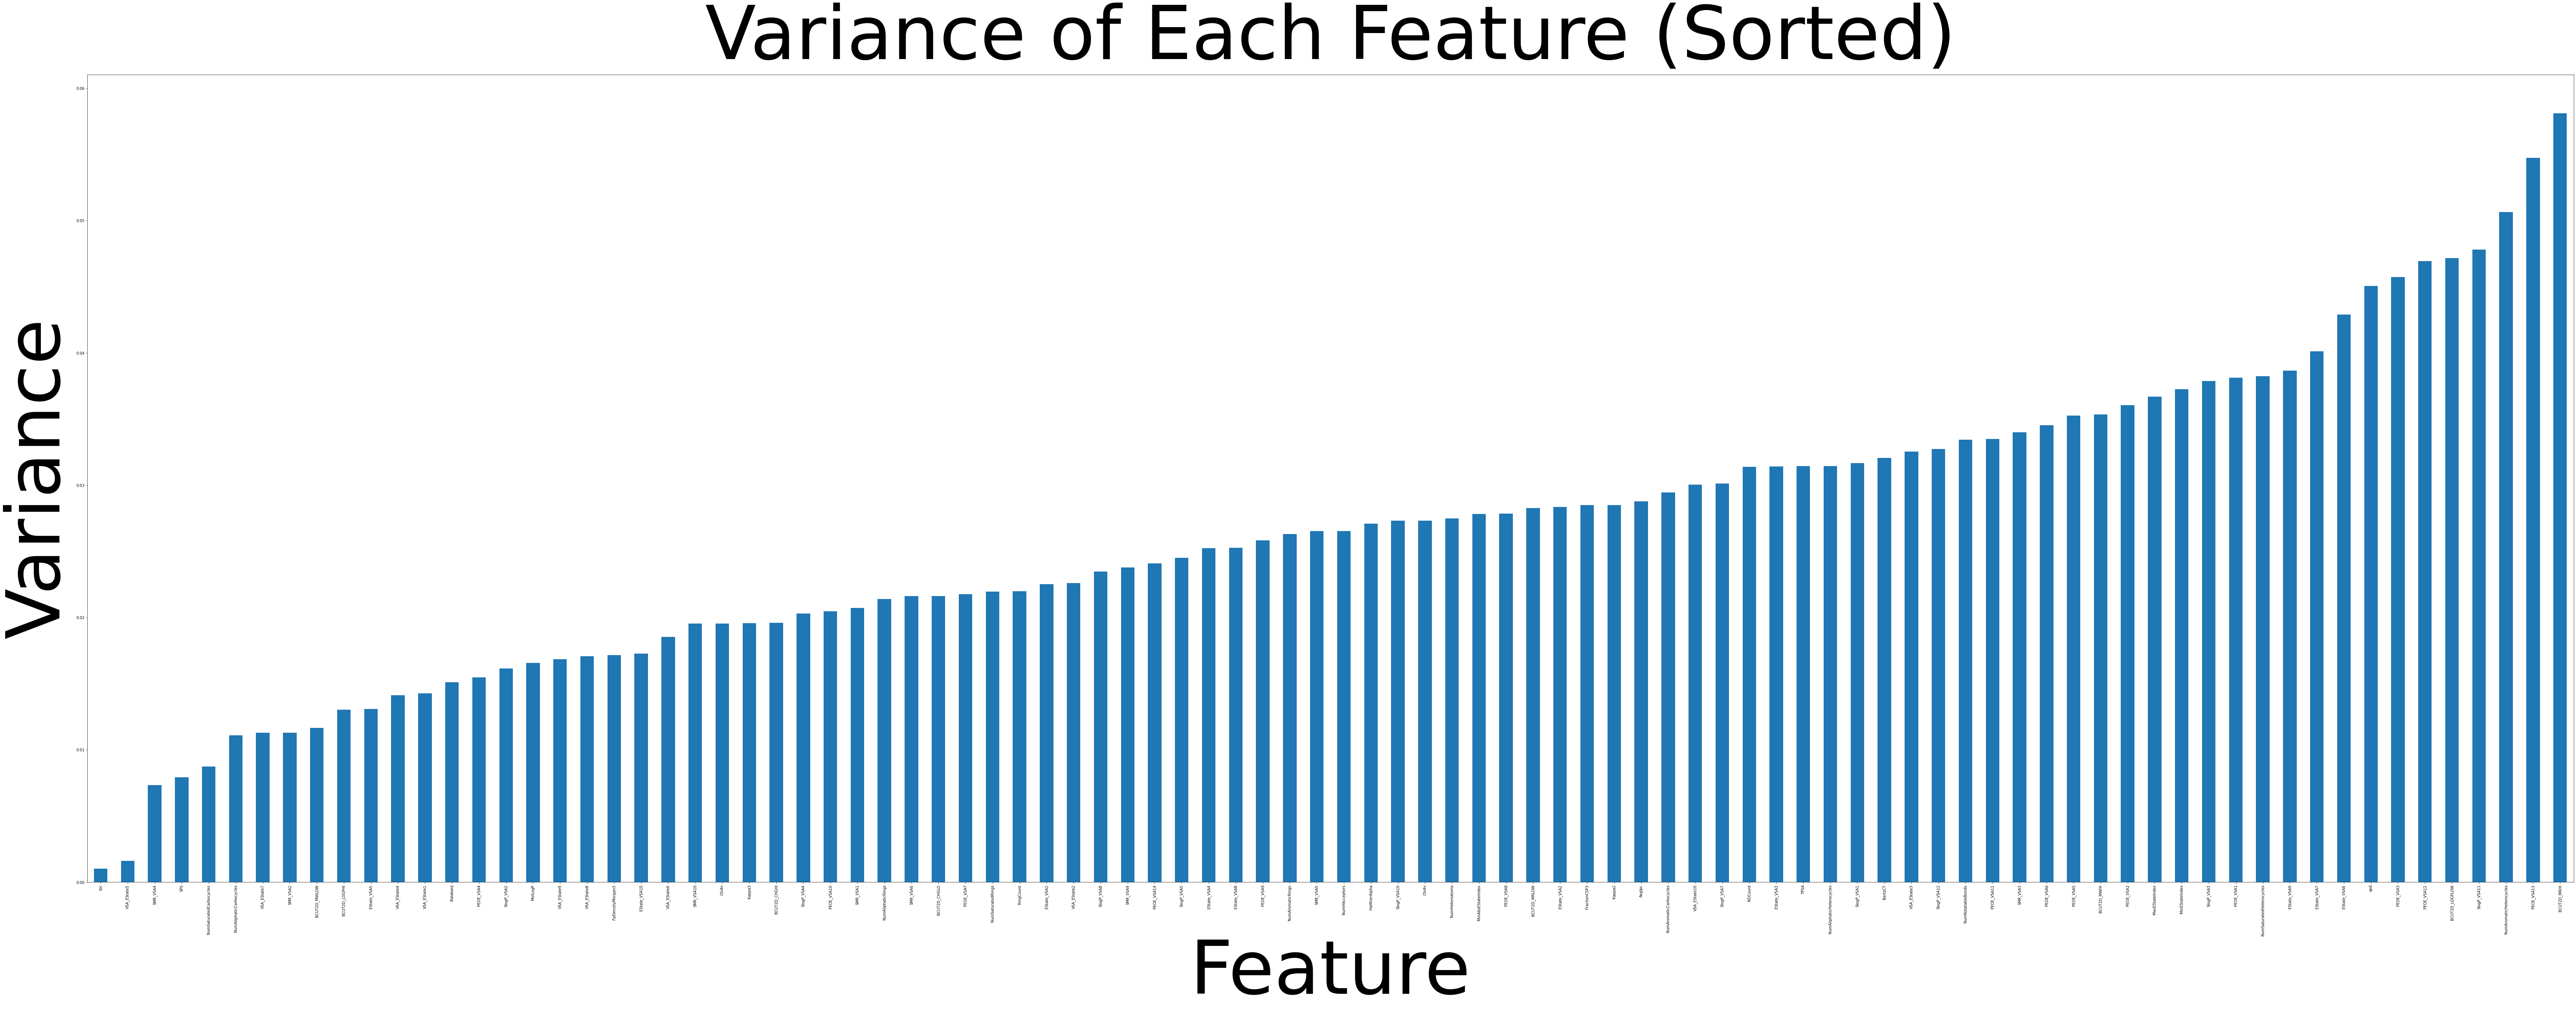

Ipc                        0.001017
VSA_EState5                0.001610
SMR_VSA4                   0.007347
SPS                        0.007930
NumSaturatedCarbocycles    0.008750
dtype: float64

In [28]:
# Scales data between 0 and 1
minmax_scaler = MinMaxScaler()

minmax_data = minmax_scaler.fit_transform(data)
scaled_df = pd.DataFrame(minmax_data, columns=data.columns)
scaled_df.head()

# Calculate variance of each feature
variances = scaled_df.var()

# Sort variances
variances_sorted = variances.sort_values()

# Plot sorted variances
plt.figure(figsize=(120, 40))
variances_sorted.plot(kind='bar')
plt.ylabel('Variance', fontdict={'fontsize' : 200})
plt.xlabel('Feature', fontdict={'fontsize' : 200})
plt.title('Variance of Each Feature (Sorted)', fontdict={'fontsize' : 200})
plt.show()

variances_sorted.head()

In [ ]:
# Plot a single variable (column)
variable = 'Ipc'
plt.figure(figsize=(10, 6))
plt.plot(scaled_df[variable])
plt.title(f'Line Plot of {variable}')
plt.xlabel('Index')
plt.ylabel(variable)
plt.show()

In [22]:
# Set the variance threshold
threshold = 0.01

# Apply VarianceThreshold
selector = VarianceThreshold(threshold)
data_high_variance = selector.fit_transform(scaled_df)

# Get the mask of retained features
retained_features_mask = selector.get_support()

# Filter the original dataframe to retain only high variance columns
high_variance_columns = scaled_df.columns[retained_features_mask]
minmax_data = scaled_df[high_variance_columns]

### Principal Component Analysis

In [38]:
# Initialize the 2D PCA
pca = PCA()

# Applies SVD to find the features with the most variance
data_pca = pca.fit_transform(minmax_data)

#### All molecules

##### Scree plot

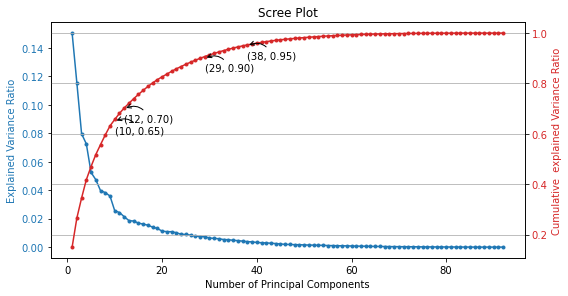

In [39]:
n_features = data.shape[1]
pca_features = PCA(n_components=n_features)
pca_features.fit(minmax_data)

# Calculate explained variance ratio
explained_variance_ratio = pca_features.explained_variance_ratio_

fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot the EVR of each component (feature)
color = 'tab:blue'
ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Explained Variance Ratio', color=color)
ax1.plot(np.arange(1, n_features+1), explained_variance_ratio, marker='.', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Plot the cumulative EVR of each component
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Cumulative  explained Variance Ratio', color=color)
ax2.plot(np.arange(1, n_features+1), np.cumsum(explained_variance_ratio), marker='.', linestyle='-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add annotations for specific points
thresholds = [0.65, 0.70, 0.90, 0.95]
for threshold in thresholds:
    index = np.argmax(np.cumsum(explained_variance_ratio) >= threshold)
    plt.annotate(f'({index+1}, {threshold:.2f})',
                 xy=(index+1, threshold),
                 xytext=(index+1, threshold - 0.05),
                 arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3,rad=0.5'))

fig.tight_layout()
plt.title('Scree Plot')
plt.grid(True)
plt.show()

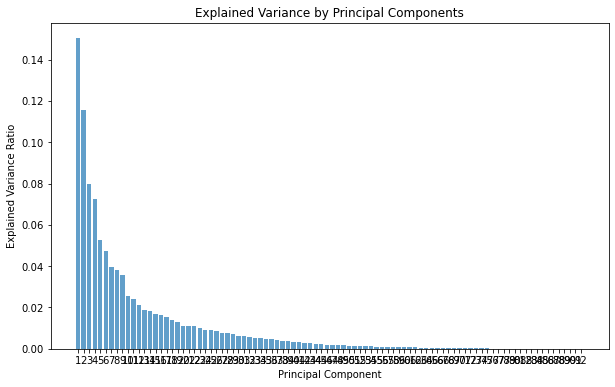

In [31]:
# Create bar plot of the PC explained variance

# Explained variance
explained_variance = pca_features.explained_variance_ratio_

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.title('Explained Variance by Principal Components')
plt.xticks(range(1, len(explained_variance) + 1))
plt.show()

##### Visualization PCA 2D

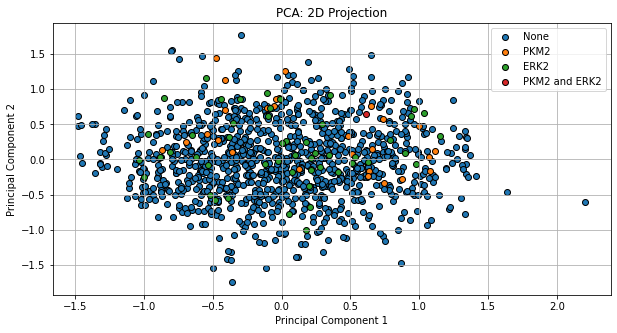

In [32]:
# Plot the PC1 and PC2 with different colors matching the classes
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.scatter(data_pca[labels['Class'] == i, 0], data_pca[labels['Class'] == i, 1], label=class_labels[i], edgecolor='k')
plt.title('PCA: 2D Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

##### Visualization PCA 2D

In [ ]:
# Plot the PC1 and PC2 with different colors matching the classes
plt.figure(figsize=(10, 5))
for i in range(1,4):
    plt.scatter(data_pca_filtered[labels_filtered['Class'] == i, 0], data_pca_filtered[labels_filtered['Class'] == i, 1], label=class_labels[i], edgecolor='k')
plt.title('PCA: 2D Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

#### Loadings

In [40]:
pca = PCA()
pca.fit(minmax_data)

# Get loadings (eigenvectors)
loadings = pca.components_

# Create a DataFrame for loadings
loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=data.columns)
loadings_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92
MaxEStateIndex,0.147039,-0.074672,0.153610,-0.013299,-0.171952,0.096223,-0.171976,0.058077,-0.030935,0.073741,...,0.000235,-0.004728,-0.002672,-0.001891,0.003450,2.748828e-16,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00
MinAbsEStateIndex,-0.107410,0.058486,-0.106577,0.019226,0.080859,-0.021474,0.163661,-0.116766,-0.040589,-0.041251,...,0.001845,0.002724,0.000348,0.002687,-0.000185,2.407615e-16,3.655433e-17,-2.055651e-17,2.324043e-17,6.406788e-17
MinEStateIndex,-0.104828,0.070114,-0.283634,-0.036972,0.100580,-0.089335,-0.256787,0.016672,-0.052337,-0.036168,...,0.022405,-0.023272,0.004276,-0.008348,-0.000491,1.137811e-16,-2.072145e-16,1.006720e-16,1.214928e-16,-2.038102e-16
qed,-0.151235,-0.191150,0.079846,-0.041873,0.022831,0.129608,0.059884,0.044350,-0.043670,-0.142244,...,0.003014,-0.011180,0.001143,0.004973,-0.001197,-7.683968e-17,9.830939e-17,5.798833e-17,-8.978643e-17,4.278359e-19
SPS,0.029437,-0.111279,-0.048066,0.072535,-0.004055,0.023553,0.026744,0.071968,-0.089611,0.047765,...,-0.154977,-0.069212,-0.071503,-0.016175,-0.009444,-5.660240e-16,-5.677971e-16,5.712754e-16,8.791097e-16,9.981541e-17


## Two types of loading plots

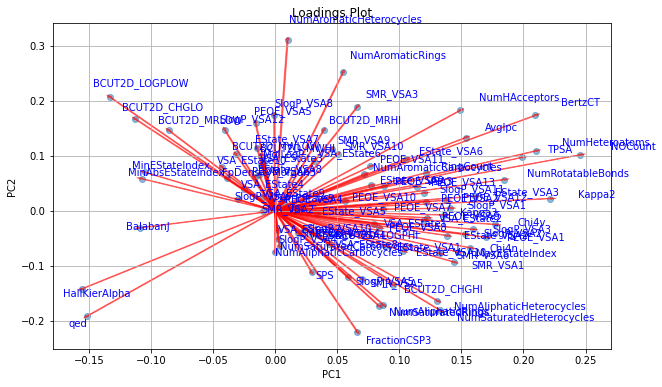

In [41]:
# Plot loadings
plt.figure(figsize=(10, 6))
plt.scatter(loadings_df['PC1'], loadings_df['PC2'], alpha=0.5)
for feature in loadings_df.index:
    plt.arrow(0, 0, loadings_df.loc[feature, 'PC1'], loadings_df.loc[feature, 'PC2'], color='r', alpha=0.5)
    plt.text(loadings_df.loc[feature, 'PC1']*1.1, loadings_df.loc[feature, 'PC2']*1.1, feature, color='b')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Loadings Plot')
plt.grid(True)
plt.show()

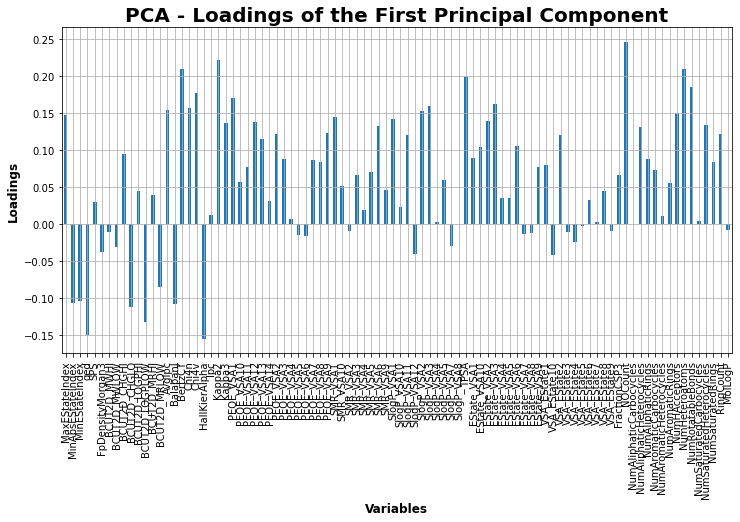

In [42]:
# Plot the loadings of the first principal component
fig, ax = plt.subplots(figsize=(12, 6))
loadings_df['PC1'].plot(kind='bar', ax=ax, legend=False)
ax.set_xlabel('Variables', fontdict = {'fontweight' : 'bold', 'fontsize' : 12})
ax.set_ylabel('Loadings', fontdict = {'fontweight' : 'bold', 'fontsize' : 12})
ax.set_title('PCA - Loadings of the First Principal Component', fontdict = {'fontweight' : 'bold', 'fontsize' : 20})
ax.grid(True)

### TSNE (maybe)